## Домашнее задание 1. Анализ данных фондового рынка. 
### Анализируются дневные данные.

1. Собрать данные по дневным ценам активов (акций) и дневным объемам продаж на заданном фондовом рынке за указанный период. Добавить (если нет) данные по индексу рынка. 
2. Преобразовать данные по ценам в данные по доходностям (используйте логарифмическую доходность). Вычислите оценки ожидаемых доходностей и стандартных отклонений и постройте «карту» активов в системе координат (σ, E). 
3. Рассмотрите портфель с равными долями капитала и отметьте его на карте активов в системе координат   (σ, E).  Дайте характеристику этому портфелю.
4.	Рассмотрите индекс рынка и отметьте его на карте активов в системе координат   (σ,E). Дайте характеристику индексу рынка.  
5.	Задайте уровень риска и оцените VaR (Value at Risk = Сумма под Риском) для активов вашего рынка. Какой из активов наиболее предпочтителен по этой характеристике?  Где он расположен на карте активов? Дайте характеристику VaR портфеля с равными долями и индекса рынка.
6.	Выберите несколько интересных (значимых)  активов рынка.   Можно ли считать наблюдаемые доходности (объемы продаж) конкретного актива повторной выборкой из некоторого распределения (белый шум)?  Поищите научные подходы к ответу на этот вопрос (проверка гипотезы о случайности, Ивченко Г.И. Медведев Ю.И. Введение в математическую статистику)
7.	Выберите несколько интересных (значимых)  активов рынка из разных производственных секторов.   В предположении, что наблюдаемые доходности (объемы продаж) являются повторной выборкой из некоторого распределения исследовать (выборочно) распределения доходностей и объемов продаж выбранных активов. Сделать выводы. 
8.	Исследовать зависимости (выборочно) между доходностями различных активов с помощью техники анализа зависимостей. Сделайте анализ зависимостей между парами активов для активов из одного производственного сектора и для активов из разных производственных секторов. Сделайте анализ зависимости (выборочно) между доходностями и объемами продаж одного актива. Рассмотрите активы из разных производственных секторов. 
9.	Бонус. Попробуйте найти что-нибудь интересное (необычное) на вашем рынке. Используйте любые известные вам методы анализа данных (data mining). 

In [1]:
import pandas as pd
import numpy as np
import bovespaparser.bovespaparser as bvparser
import math
import matplotlib.pyplot as plt
import copy
import scipy.stats as st

### 1. Собрать данные по дневным ценам активов (акций) и дневным объемам продаж на заданном фондовом рынке за указанный период. Добавить (если нет) данные по индексу рынка.

Датасет по ценам акций скачан с официального сайта крупнейшей фондовой биржи Латинской Америки: www.b3.com.br (для парсинга данных был использован модуль bovespaparser, который также удалил все строки с пропущенными значениями в датасете).

Датасет по индексу рынка скачан с yahoo finance: https://finance.yahoo.com/quote/%5EBVSP/history?period1=1514764800

In [2]:
stocks_file = 'COTAHIST_A2018.txt'
with open(stocks_file) as file:
    result = bvparser.parsedata(file)

In [3]:
stocks = pd.DataFrame(result, columns =['ticker', 'date', 'open', 'low', 'high', 'close', 'volume'])
#stocks.to_excel('stocks.xlsx')

Таким образом мы имеем данные по дате, тикеру, цене на момент открытия торгов, минимальной цене,максимальной цене, а также цене на момент закрытия торгов, объему продаж.

In [4]:
def get_tickers(stocks):
    tickers = set()
    for ticker in stocks['ticker']:
        tickers.add(ticker)
    return list(tickers)

Была проведена очистка данных: для этого мы удалили все данные, количество наблюдений за которыми было менее 245 дней (247 рабочих дней + 2 дня пропущены в датасете по индексу рынка)

In [5]:
def clean_stocks_data(stocks):
    tickers = get_tickers(stocks)
    bad_indexes = []
    for ticker in tickers:
        data_by_ticker = stocks[stocks['ticker']==ticker]
        if len(data_by_ticker) < 245:
            for i in data_by_ticker.index.values:
                bad_indexes.append(i)

    return stocks.drop(bad_indexes)

In [6]:
stocks = clean_stocks_data(stocks)
tickers = get_tickers(stocks)

In [7]:
#загружаем индекс рынка
index_file = '^BVSP.csv'
ibovespa = pd.read_csv(index_file)
ibovespa = ibovespa.rename(columns ={'Date': 'date', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Close': 'close', 'Adj Close': 'adj_close', 'Volume': 'volume'})
ibovespa['date']=ibovespa['date'].astype(np.datetime64)
bad_indexes = ibovespa[np.isnan(ibovespa['close'])].index.values
ibovespa = ibovespa.drop(bad_indexes)
#np.isnan(ibovespa.loc[18]['close_index'])

In [8]:
#dataset = pd.merge(left=stocks, right=ibovespa, left_on='date', right_on='date')
#dataset

### 2. Преобразовать данные по ценам в данные по доходностям (используйте логарифмическую доходность). Вычислите оценки ожидаемых доходностей и стандартных отклонений и постройте «карту» активов в системе координат (σ, E).

Необходимо было из данных по ценам получить данные по доходностям. Для этого использовалась логарифмическая доходность (отношение цены закрытия текущего дня к предыдущему).

Для первого дня доходность не определялась и заполнялась как неизвестная (NaN).

Для вычисления ожидаемой доходности и риска использовались встроенные функции (мат ожидание и стандартное отклонение).

In [9]:
stocks['R'] = np.NaN
E = []
sigma = []
for ticker in tickers:
    data_by_ticker = stocks[stocks['ticker']==ticker] #
    curr = data_by_ticker["close"][1:].values
    prev = data_by_ticker["close"][:-1].values
    R = np.log(curr / prev)
    stocks.loc[stocks['ticker']==ticker, 'R'] = [np.NaN, *R]
    E.append(np.mean(stocks.loc[stocks['ticker']==ticker, 'R']))
    sigma.append(np.std(stocks.loc[stocks['ticker']==ticker, 'R']))

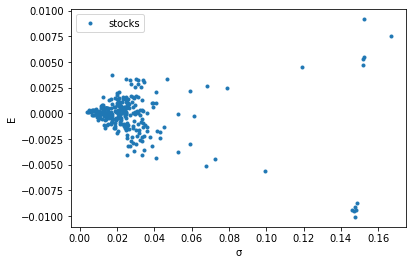

In [10]:
fig, ax = plt.subplots()

plt.xlabel('σ')
plt.ylabel('E')
ax.plot(sigma, E, '.', label='stocks')
ax.legend()
plt.show()

По полученным данным видно, что большинство данных обладают невысокой доходностью и степенью риска. Ожидаемая доходность большинства активов близка к 0. С увеличением доходности - растет риск, а плотность точек уменьшается.

Есть активы с отрицательной доходностью, однако нет безрисковых активов (т.е. риск = 0).

Активо расположены почти симметрично относительно нулевой доходности $E = 0$.

### 3. Рассмотрите портфель с равными долями капитала и отметьте его на карте активов в системе координат (σ, E). Дайте характеристику этому портфелю.

Рассмотрим портфель с равными долями: во все активы одинаково вложились.

$E = \frac{1}{N} * \sum_{i=1}^N E_i$ - ожидаемая доходность,

$\sigma^2 =  \frac{1}{N^2} * \sum_{i=1}^N \sum_{j=1}^N \sigma_{ij}$ - риск,

где $\sigma_{ij}$ - элемент ковариационной матрицы.

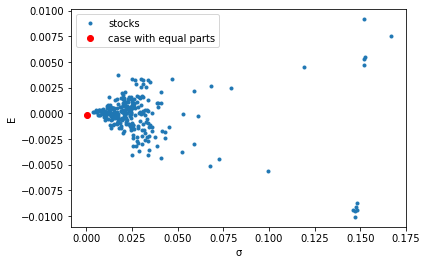

In [11]:
proportion = 1 / len(tickers)
E_equal = proportion * sum(E)
cov_matrix = []
for i in range(len(tickers)):
    for j in range(i, len(tickers)):
        x = list(stocks.loc[stocks['ticker']==tickers[i], 'R'][1:])
        y = list(stocks.loc[stocks['ticker']==tickers[j], 'R'][1:])
        if i != j:
            cov_matrix.append(np.cov(x, y)[0][1])
            cov_matrix.append(np.cov(x, y)[0][1])
        else:
            cov_matrix.append(np.cov(x, y)[0][1])
sigma_equal = proportion ** 2 * sum(cov_matrix)
ax.plot(sigma_equal, E_equal, 'ro', label='case with equal parts')
ax.legend()
fig

In [12]:
E_equal, sigma_equal

(-0.00016943375624514252, 8.276661720439272e-05)

Таким образом получаем портфель с координатами (-0.00016943375624514236, 8.276661720439148e-05), его нельзя считать значимым, так как при минимально возможном риск мы имеем отрицательную ожидаемую доходность.

Т.е. можно сделать вывод, что вкладываться в портфель с равными долями в данном случае нерационально.

### 4. Рассмотрите индекс рынка и отметьте его на карте активов в системе координат (σ,E). Дайте характеристику индексу рынка.

Рассмотрим индекс рынка (IBOVESPA) индекс общей доходности, включающий наиболее представительные компании на рынке, как по рыночной капитализации, так и по объему торгов. Это эталонный индекс фондовой биржи Сан-Паулу.

Включает в себя 60 компаний, торгуемых на рынке и на которые приходится большая часть торговой и рыночной капитализации бразильского фондового рынка.

0.0004948421514341029 0.01400936665551083


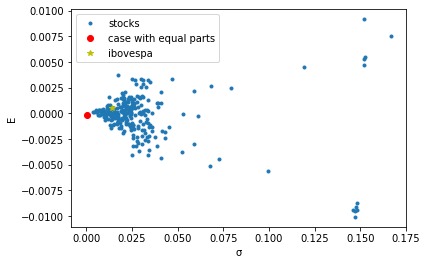

In [13]:
ibovespa['R'] = np.NaN
close_price = ibovespa['close']
return_log = np.log(close_price.pct_change() + 1)
return_log.fillna(0, inplace = True)
ibovespa.loc[:,'R'] = return_log
E_index = np.mean(return_log)
sigma_index = np.std(return_log)
print(E_index, sigma_index)
ax.plot(sigma_index, E_index, 'y*', label='ibovespa')
ax.legend()
fig

Ожидаемая доходность и риск индекса рынка следующие 0.0004948421514341029, 0.01400936665551083.

На графике наглядно видно, что ожидаемая доходность индекса рынка выше чем доходность портфеля с равными долями (однако и риск также выше).

### 5. Задайте уровень риска и оцените VaR (Value at Risk = Сумма под Риском) для активов вашего рынка. Какой из активов наиболее предпочтителен по этой характеристике? Где он расположен на карте активов? Дайте характеристику VaR портфеля с равными долями и индекса рынка.

Рассмотрим два уровня доверия (90%, 95%) и посчитаем значение $VaR$ для заданного уровня риска.

Т. е. с вероятностью 90% - 95% мы потеряем не более, чем $VaR$.

In [14]:
VaR_90 = []
VaR_95 = []
for ticker in tickers:
    sorted_r = copy.deepcopy(stocks.loc[stocks['ticker']==ticker, 'R']).sort_values()
    VaR_90.append(sorted_r.quantile(0.1))
    VaR_95.append(sorted_r.quantile(0.05))

-0.0038917965150124904 CPTS11B


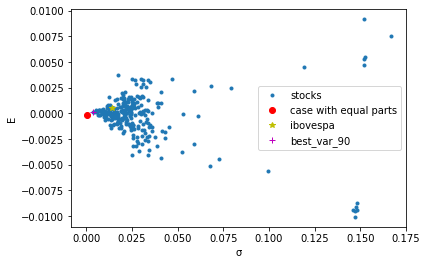

In [15]:
#находим самый предпочительный актив по VaR_90
best_var_90 = max(VaR_90)
i_best_var_90 = VaR_90.index(best_var_90)
print(best_var_90, tickers[i_best_var_90])
ax.plot(sigma[i_best_var_90], E[i_best_var_90], 'm+', label='best_var_90')
ax.legend()
fig

-0.006739142025392312 CPTS11B


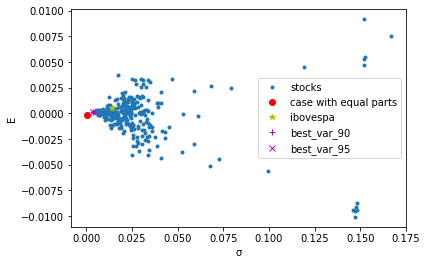

In [16]:
#находим самый предпочительный актив по VaR_95
best_var_95 = max(VaR_95)
i_best_var_95 = VaR_95.index(best_var_95)
print(best_var_95, tickers[i_best_var_95])
ax.plot(sigma[i_best_var_95], E[i_best_var_95], 'mx', label='best_var_95')
ax.legend()
fig

С уровнем доверия 0,9 наиболее предпочтительный актив: -0.0038917965150124904 CPTS11B

Аналогично с уровнем доверия 0,95: -0.0038917965150124904 CPTS11B

Самый безопасный - CPTS11B.
CPTS11B - это фонд недвижимости бумажного типа, то есть его ресурсы в основном используются для инвестиций в облигации и ценные бумаги. 

Такие фонды, как CPTS11B, направляют свои инвестиции в основном в дебиторскую задолженность по недвижимости, которая представляет собой инвестиции с фиксированным доходом, нацеленные на сектор недвижимости. Бумажные фонды известны своей способностью безопасно генерировать денежные средства, инвестируя в активы с фиксированным доходом.

In [17]:
R_equal = []
dates = sorted(set(stocks['date']))
for date in dates:
    R_equal.append(np.mean(stocks.loc[stocks['date']==date, 'R']))

In [18]:
#находим VaR_90, VaR_95 у портфеля с равными долями
sorted_r_equal = pd.Series(R_equal, [i for i in range(len(R_equal))]).sort_values()
VaR_90_equal = sorted_r_equal.quantile(0.1)
VaR_95_equal = sorted_r_equal.quantile(0.05)
print('VaR_90 у портфеля с равными долями: ', VaR_90_equal)
print('VaR_95 у портфеля с равными долями: ', VaR_95_equal)

VaR_90 у портфеля с равными долями:  -0.010851085393431192
VaR_95 у портфеля с равными долями:  -0.013996836174707296


In [19]:
#находим VaR_90, VaR_95 у индекса рынка
sorted_r_ibovespa = copy.deepcopy(ibovespa.loc[:,'R']).sort_values()
VaR_90_ibovespa = sorted_r_ibovespa.quantile(0.1)
VaR_95_ibovespa = sorted_r_ibovespa.quantile(0.05)
print('VaR_90 у индекса рынка: ', VaR_90_ibovespa)
print('VaR_95 у индекса рынка: ', VaR_95_ibovespa)

VaR_90 у индекса рынка:  -0.016256554725076876
VaR_95 у индекса рынка:  -0.023449860789660156


Если рассматривать портфель с равными долями и индекс рынка, то портфель с равными долями предпочтительнее.

### 6. Выберите несколько интересных (значимых) активов рынка. Можно ли считать наблюдаемые доходности (объемы продаж) конкретного актива повторной выборкой из некоторого распределения (белый шум)? Поищите научные подходы к ответу на этот вопрос (проверка гипотезы о случайности, Ивченко Г.И. Медведев Ю.И. Введение в математическую статистику)

Наиболее значимые активы отбирались при помощи коэффициента Шарпа - это сумма избыточной доходности над безрисковой ставкой в качестве соответствующей меры риск (безрисковая ставка = 0).

Коэффициент Шарпа используется для определения того, насколько хорошо доходность актива компенсирует принимаемый инвестором риск. При сравнении двух активов с одинаковым ожидаемым доходом, вложение в актив с более высоким коэффициентом Шарпа будет менее рискованным.

In [20]:
sharpe_ratio = []
for i in range(len(tickers)):
    #risk-free rate = 0
    sharpe_ratio.append(E[i] / sigma[i])
sharpe_indexes = sorted(range(len(sharpe_ratio)), key=lambda x: sharpe_ratio[x], reverse=True)

In [21]:
valuable_tickers = []
for i in sharpe_indexes[:6]:
    valuable_tickers.append(tickers[i])
print(valuable_tickers)

['IRBR3', 'CMIG3', 'CPFE3', 'CRPG5', 'MGLU3', 'UNIP3']


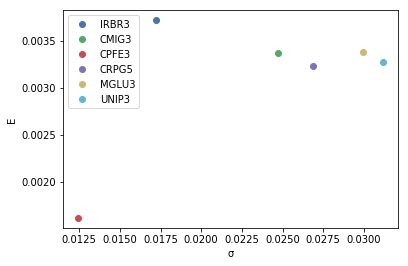

In [147]:
fig, ax = plt.subplots()
plt.xlabel('σ')
plt.ylabel('E')
for i in sharpe_indexes[:6]:
    ax.plot(sigma[i], E[i], 'o', label=tickers[i])
ax.legend()
plt.show()

Таким образом были отобраны 6 тикеров наиболее значимых компаний: IRBR3, CMIG3, CPFE3, CRPG5, MGLU3, UNIP3.

Для них необходимо рассмотреть гипотезу о случайности: наблюдения представляют собой независимые исходы случайной величины
т.е. тренда не наблюдается.

Были рассмотрены следующие критерии: автокорреляции, инверсии, Морана, Дюффа-Роя, Люнга-Бокса.

In [45]:
def inversion_test (returns, alpha):
    n = len(returns)
    N = len(returns)
    inv = 0
    for i in range(N - 1):
        for j in range(i + 1, N):
            if(returns[i] > returns[j]):
                inv += 1
    ei = (n * (n - 1)) / 4
    di = (2 * n ** 3 + 3 * n ** 2 - 5 * n) / 72
    iinv = (inv - ei) / (di ** (1 / 2))

    if (math.fabs(iinv) >= st.norm.ppf(1 - alpha / 2)):
        print("      Критерий инверсий: гипотеза отвергается")
    else:
        print("      Критерий инверсий: гипотеза принимается")

In [46]:
def autocorrelation_test(returns, alpha):
    N = len(returns)
    n = len(returns)
    #проверка на независимость векторов доходностей
    xixi = 0
    xi = 0
    xi2 = 0
    for i in range(N - 1):
        xixi += returns[i] * returns[i + 1]
    for i in range(N):            
        xi += returns[i]
        xi2 += returns[i] ** 2
    r = (N * xixi - xi ** 2 + N * returns[0] * returns[N - 1]) / (N * xi2 - xi ** 2)
    
    
    Er = - 1 / (N - 1) #mathematical expectation of r
    Dr = (N * (N - 3)) / ((N + 1) * (N - 1) ** 2) #variance of r
    
    #test normalized statistics
    rr = (r - Er) / math.sqrt(Dr)
    if (abs(rr) >= st.norm.ppf(1 - alpha / 2)):
        print("      Критерий автокорреляции: гипотеза отвергается")
    else:
        print("      Критерий автокорреляции: гипотеза принимается")
    
    
    rm = (N - 1) ** (1 / 2) * (N * r + 1) / (N - 2)
    if (abs(rm) >= st.norm.ppf(1 - alpha / 2)):
        print("        Критерий Морана: гипотеза отвергается")
    else:
        print("        Критерий Морана: гипотеза принимается")
    
    
    rlb = (N * (N + 2) / (N - 1)) ** (1 / 2) * r
    if (abs(rlb) >= st.norm.ppf(1 - alpha / 2)):
        print("   Критерий Люнга-Бокса: гипотеза отвергается")
    else:
        print("   Критерий Люнга-Бокса: гипотеза принимается")
        
        
    rdr = ((N - 1) / (N * (N - 2))) ** (1 / 2) * (N * r + 1)
    if (abs(rdr) >= st.norm.ppf(1 - alpha / 2)):
        print("     Критерий Дюффа-Роя: гипотеза отвергается")
    else:
        print("     Критерий Дюффа-Роя: гипотеза принимается")

In [48]:
alpha = 0.05
for i in sharpe_indexes[:6]:
    print('Для ', tickers[i], ':')
    inversion_test(list(stocks.loc[stocks['ticker']==tickers[i], 'R']), alpha)
    autocorrelation_test(list(stocks.loc[stocks['ticker']==tickers[i], 'R']), alpha)

Для  IRBR3 :
      Критерий инверсий: гипотеза принимается
      Критерий автокорреляции: гипотеза принимается
        Критерий Морана: гипотеза принимается
   Критерий Люнга-Бокса: гипотеза принимается
     Критерий Дюффа-Роя: гипотеза принимается
Для  CMIG3 :
      Критерий инверсий: гипотеза принимается
      Критерий автокорреляции: гипотеза принимается
        Критерий Морана: гипотеза принимается
   Критерий Люнга-Бокса: гипотеза принимается
     Критерий Дюффа-Роя: гипотеза принимается
Для  CPFE3 :
      Критерий инверсий: гипотеза принимается
      Критерий автокорреляции: гипотеза принимается
        Критерий Морана: гипотеза принимается
   Критерий Люнга-Бокса: гипотеза принимается
     Критерий Дюффа-Роя: гипотеза принимается
Для  CRPG5 :
      Критерий инверсий: гипотеза принимается
      Критерий автокорреляции: гипотеза принимается
        Критерий Морана: гипотеза принимается
   Критерий Люнга-Бокса: гипотеза принимается
     Критерий Дюффа-Роя: гипотеза принимается
Для 

Как показывают результаты, для всех доходностей акций гипотезы о случайности принимаются при заданном уровне значимости $\alpha = 0.5$. Из этого можно сделать вывод, что данные в выборках можно считать случайными.

### 7. Выберите несколько интересных (значимых) активов рынка из разных производственных секторов. В предположении, что наблюдаемые доходности (объемы продаж) являются повторной выборкой из некоторого распределения исследовать (выборочно) распределения доходностей и объемов продаж выбранных активов. Сделать выводы.

1) IRBR3 - Sector(s): Financial Services, Industry: Insurance—Reinsurance

2) CMIG3 - Sector(s): Utilities, Industry: Utilities—Diversified

3) CPFE3 - Sector(s): Utilities, Industry: Utilities—Regulated Electric

4) CRPG5 - Sector(s): Basic Materials, Industry: Chemicals

5) MGLU3 - Sector(s): Consumer Cyclical, Industry: Specialty Retail

In [61]:
def check_norm_distr(ticker, feature, alpha):
    print("Для: ", ticker)
    v = list(stocks.loc[stocks['ticker']==ticker, feature][1:])
    hyp = st.kstest(v, 'norm')
    if (hyp[1] < alpha):
        print("Критерий Колмогорова-Смирнова: гипотеза отвергается; p-value: ",hyp[1])
    else:
        print("Критерий Колмогорова-Смирнова: гипотеза принимается; p-value: ",hyp[1])

    hyp = st.shapiro(v)
    if (hyp[1] < 0.05):
        print("        Критерий Шапиро-Уилка: гипотеза отвергается; p-value: ",hyp[1])
    else:
        print("        Критерий Шапиро-Уилка: гипотеза принимается; p-value: ",hyp[1])

    hyp = st.normaltest(v)
    if(hyp[1] < 0.05):
        print("          Критерий Д'Агостино: гипотеза отвергается; p-value: ",hyp[1])
    else:
        print("          Критерий Д'Агостино: гипотеза принимается; p-value: ",hyp[1])
        

In [56]:
def plot_by_time(set_tickers, feature):
    plt.figure(figsize=(10,6))
    plt.xlabel("time")
    plt.ylabel(feature)
    for ticker in set_tickers:
        returns = stocks.loc[stocks['ticker']==ticker, feature]
        array = returns.values
        time = stocks.loc[stocks['ticker']==ticker, 'date']
        plt.plot(time, array)
    plt.legend(labels=set_tickers)
    plt.show()

In [57]:
def plot_hist(set_tickers, feature, alpha):
    plt.style.use('seaborn-deep')
    x = [stocks.loc[stocks['ticker']==set_tickers[i], feature] for i in range(len(set_tickers))]
    plt.hist(x, bins = 20, label=set_tickers)
    plt.legend(loc='upper right')
    plt.show()
    for i in range(len(set_tickers)):
        check_norm_distr(set_tickers[i], feature, alpha)

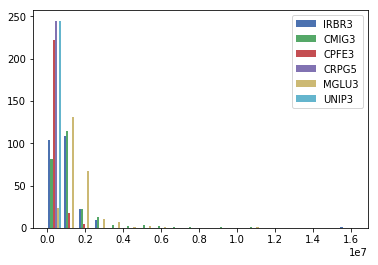

Для:  IRBR3
Критерий Колмогорова-Смирнова: гипотеза отвергается; p-value:  0.0
        Критерий Шапиро-Уилка: гипотеза отвергается; p-value:  5.785340922991164e-28
          Критерий Д'Агостино: гипотеза отвергается; p-value:  2.1047264515704945e-98
Для:  CMIG3
Критерий Колмогорова-Смирнова: гипотеза отвергается; p-value:  0.0
        Критерий Шапиро-Уилка: гипотеза отвергается; p-value:  2.715998871755458e-23
          Критерий Д'Агостино: гипотеза отвергается; p-value:  7.59077970871445e-49
Для:  CPFE3
Критерий Колмогорова-Смирнова: гипотеза отвергается; p-value:  0.0
        Критерий Шапиро-Уилка: гипотеза отвергается; p-value:  1.5091937159399898e-18
          Критерий Д'Агостино: гипотеза отвергается; p-value:  7.93403203222624e-35
Для:  CRPG5
Критерий Колмогорова-Смирнова: гипотеза отвергается; p-value:  0.0
        Критерий Шапиро-Уилка: гипотеза отвергается; p-value:  7.170655353165806e-17
          Критерий Д'Агостино: гипотеза отвергается; p-value:  2.1215927887988842e-26
Для

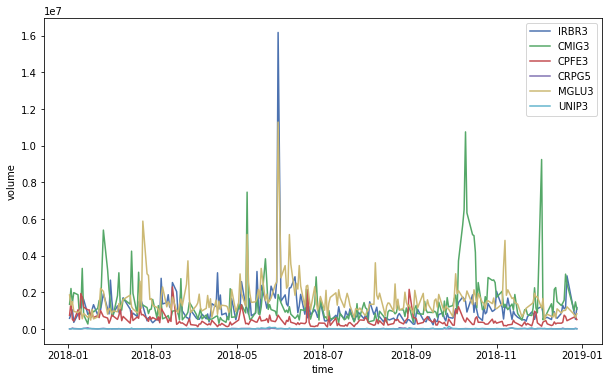

In [62]:
alpha = 0.05
plot_hist(valuable_tickers, 'volume', alpha)
plot_by_time(valuable_tickers, 'volume')

In [12]:
def R(ticker):
    s1=list(stocks.loc[stocks['ticker']==ticker,'close'])
    s2=[]
    for i in range(1,len(s1)):
        s2.append(math.log(s1[i]/s1[i-1]))
    return s2    
def vol(ticker):
    s1=list(stocks.loc[stocks['ticker']==ticker,'volume'])
    return s1

### 8. Исследовать зависимости (выборочно) между доходностями различных активов с помощью техники анализа зависимостей. Сделайте анализ зависимостей между парами активов для активов из одного производственного сектора и для активов из разных производственных секторов. Сделайте анализ зависимости (выборочно) между доходностями и объемами продаж одного актива. Рассмотрите активы из разных производственных секторов.

# Тест активов из одного сектора

In [77]:
def corr(ticker1,ticker2):
    plt.scatter(ticker1,ticker2, c = 'red')
    plt.xlabel("Ticker 1")
    plt.ylabel("Ticker 2")
    plt.show()
    print('Коэффициент корреляции ' ,np.corrcoef(ticker1,ticker2)[1][0])
    return np.corrcoef(ticker1,ticker2)[1][0]

Unip3 и CRPG5 компании из химеческой отрасли:

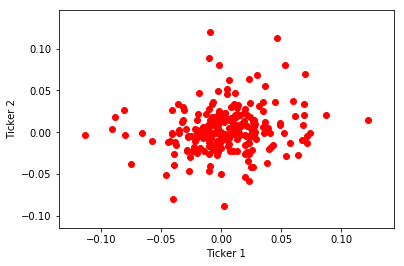

Коэффициент корреляции  0.16270542485626643


0.16270542485626643

In [50]:
corr(R('UNIP3'),R('CRPG5'))

Несмотря на то ,что компании из одного сектора, корреляция между данными крайне  мала, так что можно сказать, что данные независимы.

# Тест активов из разных секторов

CPFE3 из сектора электроснабжения , CRPG5 из химического сектора:

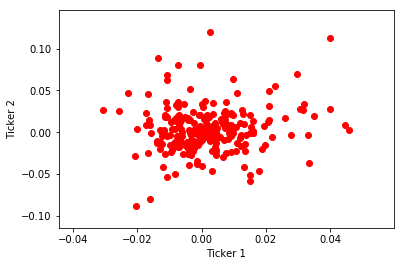

Коэффициент корреляции  0.11739592987662795


0.11739592987662795

In [52]:
corr(R('CPFE3'),R('CRPG5'))

Как и в предыдещем тесте зависимости между активами выявлено не было.

В данных тестах не было найдено зависимостей между активами однако ,если производить вычисления над всем массивом данных, можно найти зависимости между активами как в одних так и в разных секторах.

Ниже пример между двумя активами банковского сектора:

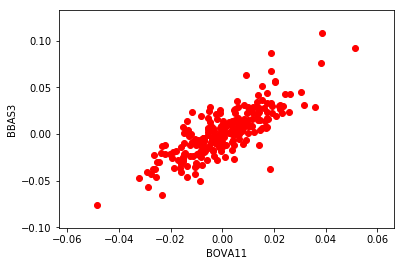

In [78]:
plt.scatter(R('BOVA11'),R('BBAS3'), c = 'red')
plt.xlabel("BOVA11")
plt.ylabel("BBAS3")
plt.show()

# Тесты доходностей и продаж

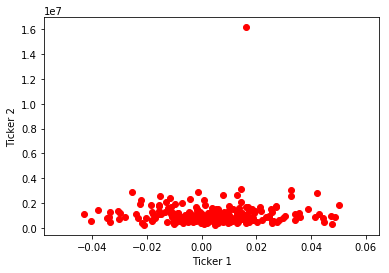

Коэффициент корреляции  0.04130722867485712


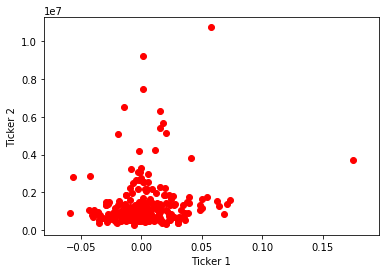

Коэффициент корреляции  0.15426967533708372


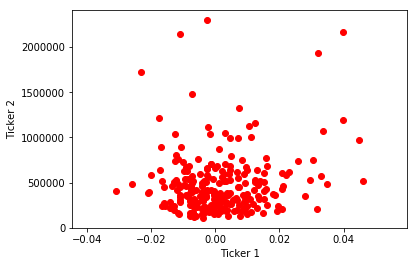

Коэффициент корреляции  0.13409503798745348


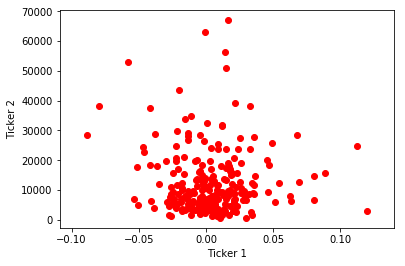

Коэффициент корреляции  -0.052257758583567473


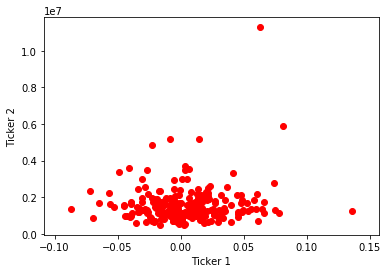

Коэффициент корреляции  0.09528354766880008


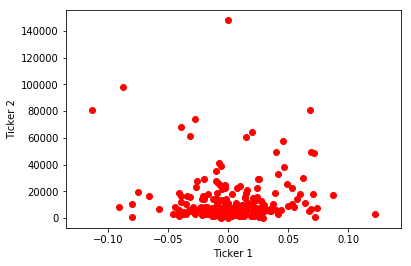

Коэффициент корреляции  -0.04157747126247989


In [53]:
for i in valuable_tickers:
    corr(R(i),vol(i)[:-1])

Зависимость между доходностями и объемами продаж не выявлено ни для одного из активов портфолио.